# Exercise: Introduction to Data Science

## Exercise 2: Time series predictive model and evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Step 0: Prepare data set

Import data from exercise 1 and drop all columns that are no longer needed

In [2]:
price_data = pd.read_csv('clean_data.csv', sep=';', index_col=0)
price_data.drop(['HOUR', 'WEEK', 'YEAR', 'WEEKDAY', 'PRICE_CHANGE', 'CHANGED'], axis=1, inplace=True)
price_data['DATE_CHANGED'] = pd.to_datetime(price_data['DATE_CHANGED'])

Choose the 100 gas stations with the longest time history

In [3]:
number_of_days = price_data.groupby('STID')['DATE'].nunique()
longest_history = number_of_days.sort_values().tail(100)
full_data_set = (price_data[price_data['STID'].isin(longest_history.index)])
small_data_set = (price_data[price_data['STID'].isin(longest_history.index[0:3])])
full_data_set.drop(['DATE'], axis=1, inplace=True)
small_data_set.drop(['DATE'], axis=1, inplace=True)

/home/johannes/.conda/envs/data_science/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Ensure that all stations have all identical time horizon (7:00 to 20:00)

In [4]:
full_data_set.set_index('DATE_CHANGED', inplace=True)
full_data_set = full_data_set.between_time('07:00', '20:00')
small_data_set.set_index('DATE_CHANGED', inplace=True)
small_data_set = small_data_set.between_time('07:00', '20:00')

Sort data by station and date and calculate the daily mean prices

In [5]:
full_data_set = full_data_set.groupby(full_data_set.index.date)['E5', 'E10', 'DIESEL'].mean() / 1000
small_data_set = small_data_set.groupby(small_data_set.index.date)['E5', 'E10', 'DIESEL'].mean() / 1000

Ensure a perfect data set, clean outlier

In [6]:
full_data_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 479 entries, 2014-06-08 to 2015-09-29
Data columns (total 3 columns):
E5        479 non-null float64
E10       479 non-null float64
DIESEL    479 non-null float64
dtypes: float64(3)
memory usage: 15.0+ KB


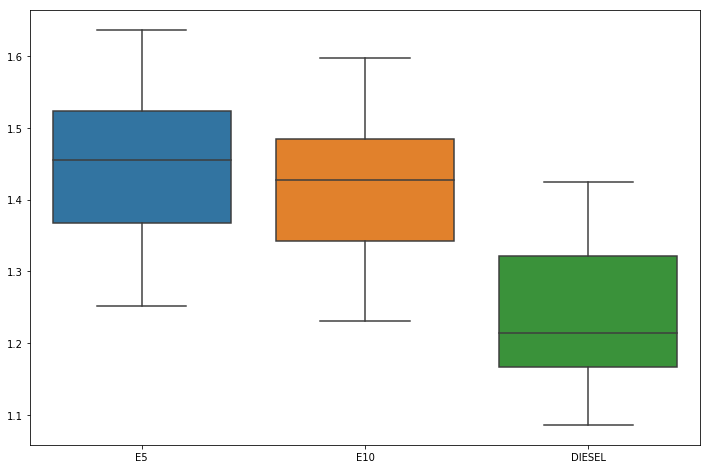

In [7]:
plt.figure(figsize=(12,8))
sns.boxplot(data=full_data_set[['E5', 'E10', 'DIESEL']])

### Step 1: Start with small (3 stations) data set and develop a simple reference model

Simple functions for moving average, MAD and MAPE

In [8]:
def simple_moving_average(df, window):
    return df.rolling(window=window).mean().shift(1)

In [9]:
def mean_absolute_deviation(df, x='x', x_hat='x_hat'):
    return abs(df[x] - df[x_hat])

In [10]:
def mean_abolute_percentage_error(df, x='x', x_hat='x_hat'):
    return abs((df[x] - df[x_hat]) / df[x]) * 100

Split data set: Two third for training and one third for testing

In [11]:
train_size = int(len(small_data_set) * 0.66)
train, test = small_data_set[0:train_size], small_data_set[train_size:len(small_data_set)]

In [12]:
reference_model = small_data_set.copy()

Calculate predicted values with simple moving average

In [13]:
reference_model['E5_hat'] = simple_moving_average(reference_model['E5'], len(train))
reference_model['E10_hat'] = simple_moving_average(reference_model['E10'], len((train)))
reference_model['DIESEL_hat'] = simple_moving_average(reference_model['DIESEL'], len(train))

In [14]:
reference_model.dropna(inplace=True)
reference_model = reference_model.reset_index()
reference_model = reference_model.rename(columns={'index': 'date'})
reference_model['date'] = reference_model['date'].apply(lambda x: x.strftime("%Y-%m-%d"))

Time series plot of 'true values' vs 'predicted values'

Text(0.5, 1.0, 'Prediction of E5 with reference model')

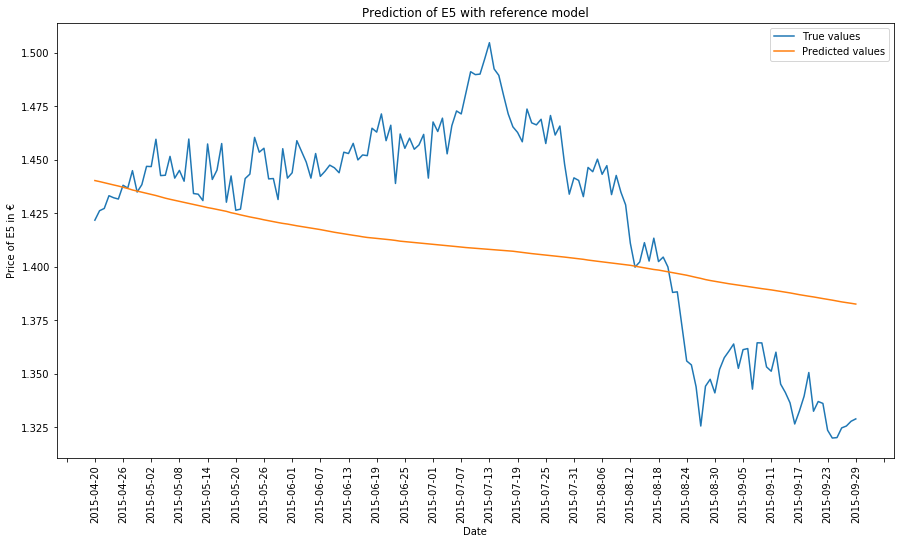

In [15]:
fig, ax = plt.subplots(figsize=(15,8))

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=90)

ax.plot(reference_model['date'], reference_model['E5'], label='True values')
ax.plot(reference_model['date'], reference_model['E5_hat'], label='Predicted values')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price of E5 in €')
plt.title('Prediction of E5 with reference model')

Text(0.5, 1.0, 'Prediction of E10 with reference model')

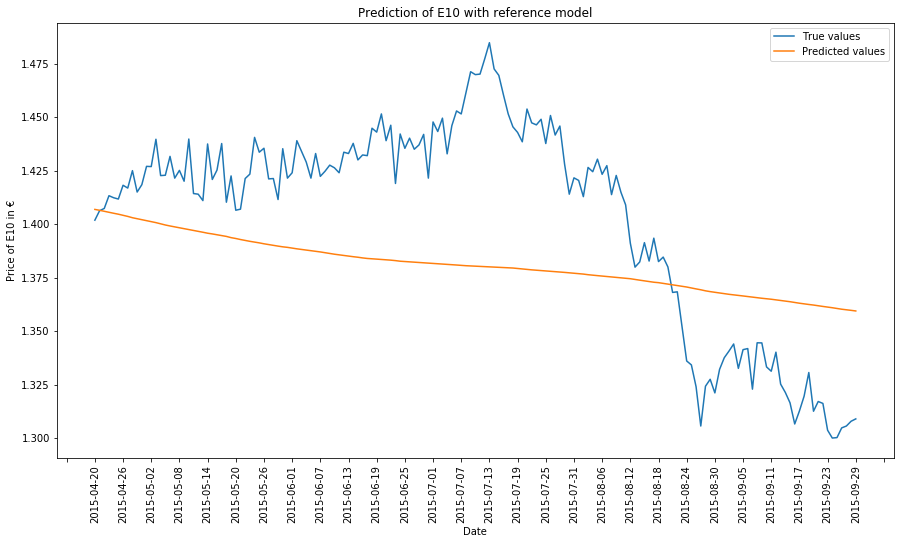

In [16]:
fig, ax = plt.subplots(figsize=(15,8))

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=90)

ax.plot(reference_model['date'], reference_model['E10'], label='True values')
ax.plot(reference_model['date'], reference_model['E10_hat'], label='Predicted values')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price of E10 in €')
plt.title('Prediction of E10 with reference model')

Text(0.5, 1.0, 'Prediction of Diesel with reference model')

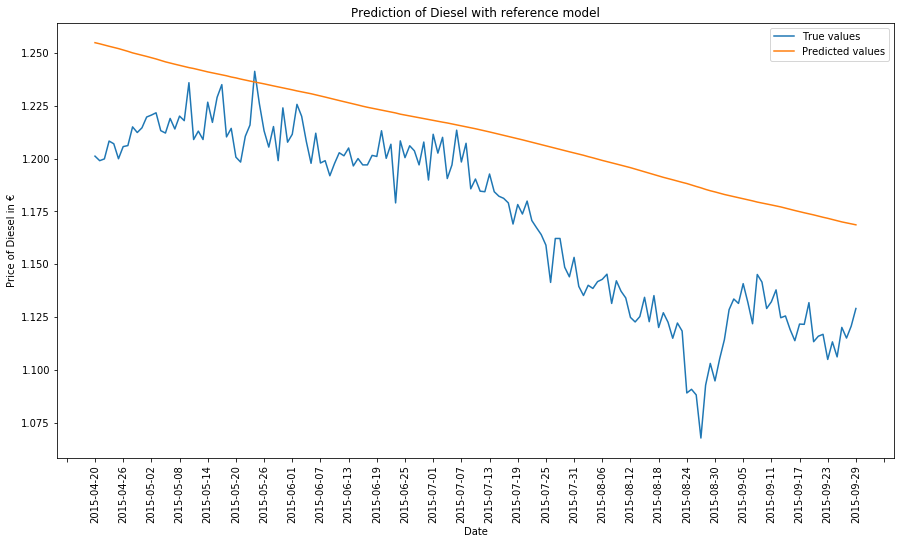

In [17]:
fig, ax = plt.subplots(figsize=(15,8))

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=90)

ax.plot(reference_model['date'], reference_model['DIESEL'], label='True values')
ax.plot(reference_model['date'], reference_model['DIESEL_hat'], label='Predicted values')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price of Diesel in €')
plt.title('Prediction of Diesel with reference model')

Calculate MAD and MAPE

In [18]:
reference_model['mad_e5'] = reference_model.apply(mean_absolute_deviation, x='E5', x_hat='E5_hat', axis=1)
reference_model['mad_e10'] = reference_model.apply(mean_absolute_deviation, x='E10', x_hat='E10_hat', axis=1)
reference_model['mad_diesel'] = reference_model.apply(mean_absolute_deviation, x='DIESEL', x_hat='DIESEL_hat', axis=1)

reference_model['mape_e5'] = reference_model.apply(mean_abolute_percentage_error, x='E5', x_hat='E5_hat', axis=1)
reference_model['mape_e10'] = reference_model.apply(mean_abolute_percentage_error, x='E10', x_hat='E10_hat', axis=1)
reference_model['mape_diesel'] = reference_model.apply(mean_abolute_percentage_error, x='DIESEL', x_hat='DIESEL_hat', axis=1)

In [19]:
reference_model.head()

,date,E5,E10,DIESEL,E5_hat,E10_hat,DIESEL_hat,mad_e5,mad_e10,mad_diesel,mape_e5,mape_e10,mape_diesel
0,2015-04-20,1.421857,1.401857,1.201143,1.440366,1.406884,1.254864,0.018509,0.005027,0.053721,1.301737,0.358573,4.472496
1,2015-04-21,1.426273,1.406273,1.199000,1.439888,1.406469,1.254339,0.013615,0.000196,0.055339,0.954583,0.013943,4.615434
2,2015-04-22,1.427333,1.407333,1.199833,1.439347,1.405992,1.253744,0.012014,0.001342,0.053911,0.841715,0.095323,4.493190
3,2015-04-23,1.433286,1.413286,1.208286,1.438846,1.405554,1.253172,0.005561,0.007732,0.044886,0.387964,0.547069,3.714862
4,2015-04-24,1.432333,1.412333,1.207000,1.438311,1.405082,1.252611,0.005978,0.007251,0.045611,0.417365,0.513402,3.778835


In [20]:
print("The average mean absolute deviation of E5: %1.4f€" %reference_model.mad_e5.mean())
print("The average mean absolute deviation of E10: %1.4f€" %reference_model.mad_e10.mean())
print("The average mean absolute deviation of Diesel: %1.4f€" %reference_model.mad_diesel.mean())
print("\n")
print("The average mean abolute percentage error of E5: %1.3f%%" %reference_model.mape_e5.mean())
print("The average mean abolute percentage error of E10: %1.3f%%" %reference_model.mape_e10.mean())
print("The average mean abolute percentage error of Diesel: %1.3f%%" %reference_model.mape_diesel.mean())

The average mean absolute deviation of E5: 0.0364€
The average mean absolute deviation of E10: 0.0419€
The average mean absolute deviation of Diesel: 0.0407€


The average mean abolute percentage error of E5: 2.560%
The average mean abolute percentage error of E10: 2.972%
The average mean abolute percentage error of Diesel: 3.536%


### Step 2: Go with a more complicated model

In [21]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


Split data set: Two third for training and one third for testing

In [22]:
train, test = np.split(full_data_set, [int(0.66 * len(full_data_set))])

Function for cross validation with prophet

In [23]:
def facebook_prophet(df, initial):
    m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
    m.fit(df)
    df_cv = cross_validation(m,
                            initial= str(initial) + ' days',
                            period='1 days',
                            horizon='1 days')
    return df_cv

Calculate predicted values with the Facebook Prophet package

In [24]:
e5_small_data_set = small_data_set.reset_index()
e5_small_data_set = e5_small_data_set.rename(columns={'index': 'ds', 'E5': 'y'})
e5_prophet = facebook_prophet(e5_small_data_set, len(train))

e10_small_data_set = small_data_set.reset_index()
e10_small_data_set = e10_small_data_set.rename(columns={'index': 'ds', 'E10': 'y'})
e10_prophet = facebook_prophet(e10_small_data_set, len(train))

diesel_small_data_set = small_data_set.reset_index()
diesel_small_data_set = diesel_small_data_set.rename(columns={'index': 'ds', 'DIESEL': 'y'})
diesel_prophet = facebook_prophet(diesel_small_data_set, len(train))

INFO:fbprophet:Making 162 forecasts with cutoffs between 2015-04-20 00:00:00 and 2015-09-28 00:00:00
INFO:fbprophet:Making 162 forecasts with cutoffs between 2015-04-20 00:00:00 and 2015-09-28 00:00:00
INFO:fbprophet:Making 162 forecasts with cutoffs between 2015-04-20 00:00:00 and 2015-09-28 00:00:00


Time series plot of 'true values' vs 'predicted values'

Text(0.5, 1.0, 'Prediction of E5 with prophet')

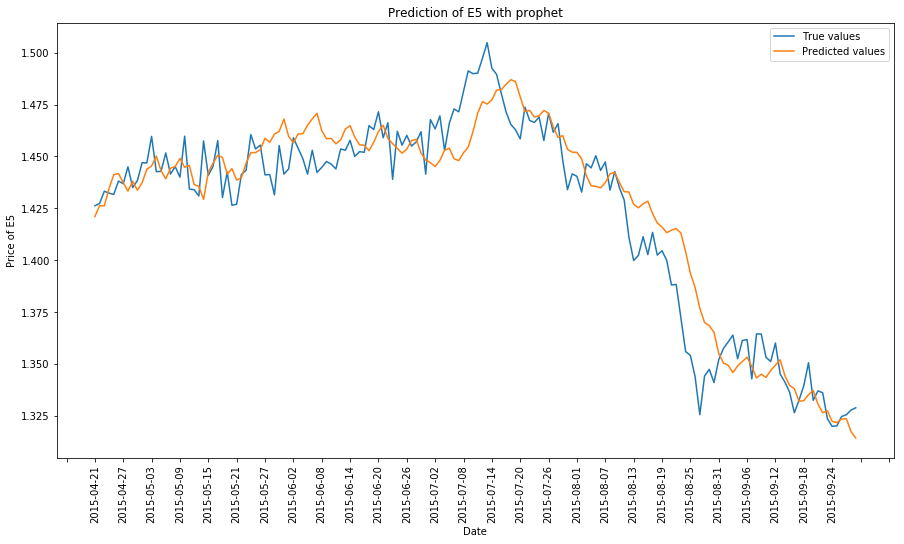

In [25]:
e5_prophet['ds'] = e5_prophet['ds'].apply(lambda x: x.date().strftime("%Y-%m-%d"))

fig, ax = plt.subplots(figsize=(15,8))

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=90)

ax.plot(e5_prophet['ds'], e5_prophet['y'], label='True values')
ax.plot(e5_prophet['ds'], e5_prophet['yhat'], label='Predicted values')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price of E5')
plt.title('Prediction of E5 with prophet')

Text(0.5, 1.0, 'Prediction of E10 with prophet')

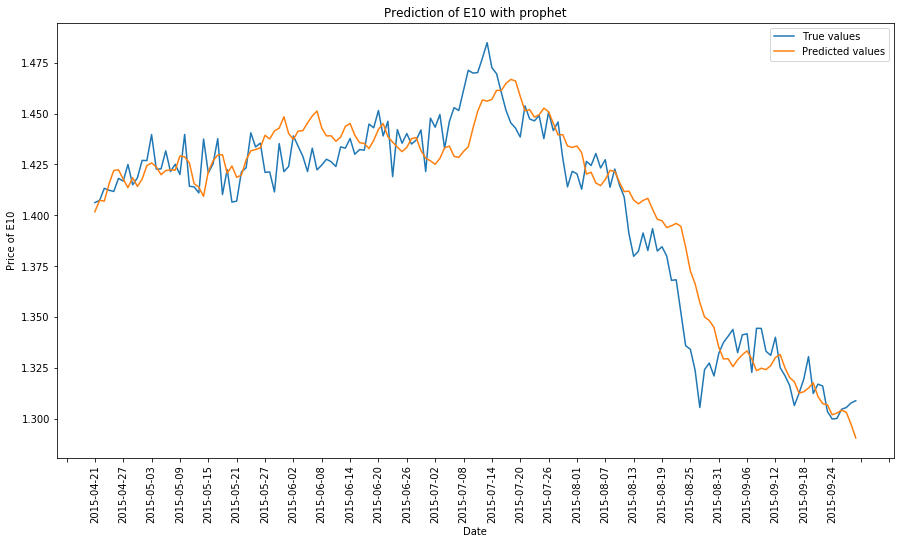

In [26]:
e10_prophet['ds'] = e10_prophet['ds'].apply(lambda x: x.date().strftime("%Y-%m-%d"))

fig, ax = plt.subplots(figsize=(15,8))

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=90)

ax.plot(e10_prophet['ds'], e10_prophet['y'], label='True values')
ax.plot(e10_prophet['ds'], e10_prophet['yhat'], label='Predicted values')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price of E10')
plt.title('Prediction of E10 with prophet')

Text(0.5, 1.0, 'Prediction of Diesel with prophet')

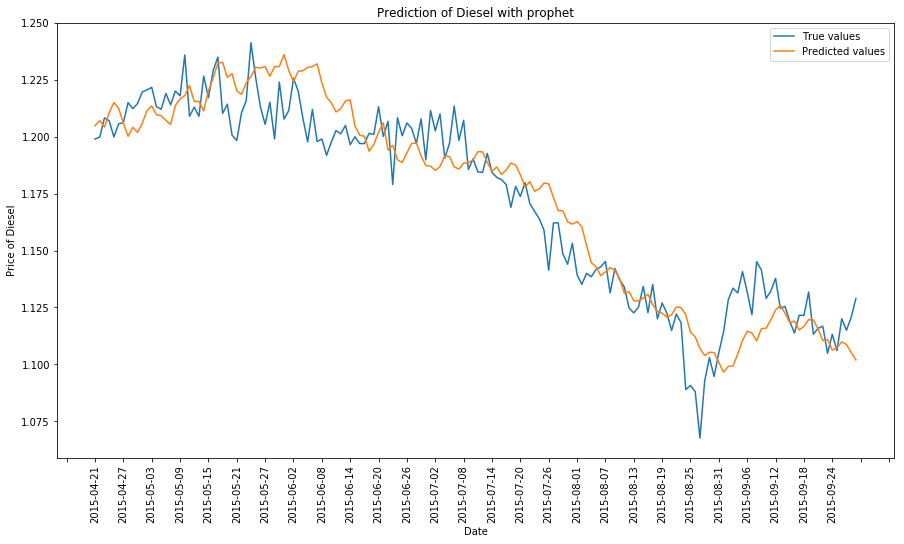

In [27]:
diesel_prophet['ds'] = diesel_prophet['ds'].apply(lambda x: x.date().strftime("%Y-%m-%d"))

fig, ax = plt.subplots(figsize=(15,8))

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=90)

ax.plot(diesel_prophet['ds'], diesel_prophet['y'], label='True values')
ax.plot(diesel_prophet['ds'], diesel_prophet['yhat'], label='Predicted values')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price of Diesel')
plt.title('Prediction of Diesel with prophet')

Calculate MAD and MAPE

In [28]:
metrics = pd.DataFrame()

metrics['mad_e5'] = e5_prophet.apply(mean_absolute_deviation, x='y', x_hat='yhat', axis=1)
metrics['mad_e10'] = e10_prophet.apply(mean_absolute_deviation, x='y', x_hat='yhat', axis=1)
metrics['mad_diesel'] = diesel_prophet.apply(mean_absolute_deviation, x='y', x_hat='yhat', axis=1)

metrics['mape_e5'] = e5_prophet.apply(mean_abolute_percentage_error, x='y', x_hat='yhat', axis=1)
metrics['mape_e10'] = e10_prophet.apply(mean_abolute_percentage_error, x='y', x_hat='yhat', axis=1)
metrics['mape_diesel'] = diesel_prophet.apply(mean_abolute_percentage_error, x='y', x_hat='yhat', axis=1)

In [29]:
print("The average mean absolute deviation of E5: %1.4f€" %metrics.mad_e5.mean())
print("The average mean absolute deviation of E10: %1.4f€" %metrics.mad_e10.mean())
print("The average mean absolute deviation of Diesel: %1.4f€" %metrics.mad_diesel.mean())
print("\n")
print("The average mean abolute percentage error of E5: %1.3f%%" %metrics.mape_e5.mean())
print("The average mean abolute percentage error of E10: %1.3f%%" %metrics.mape_e10.mean())
print("The average mean abolute percentage error of Diesel: %1.3f%%" %metrics.mape_diesel.mean())

The average mean absolute deviation of E5: 0.0119€
The average mean absolute deviation of E10: 0.0120€
The average mean absolute deviation of Diesel: 0.0117€


The average mean abolute percentage error of E5: 0.842%
The average mean abolute percentage error of E10: 0.855%
The average mean abolute percentage error of Diesel: 0.997%


Compare the prediction results against the reference model (MAD and MAPE)

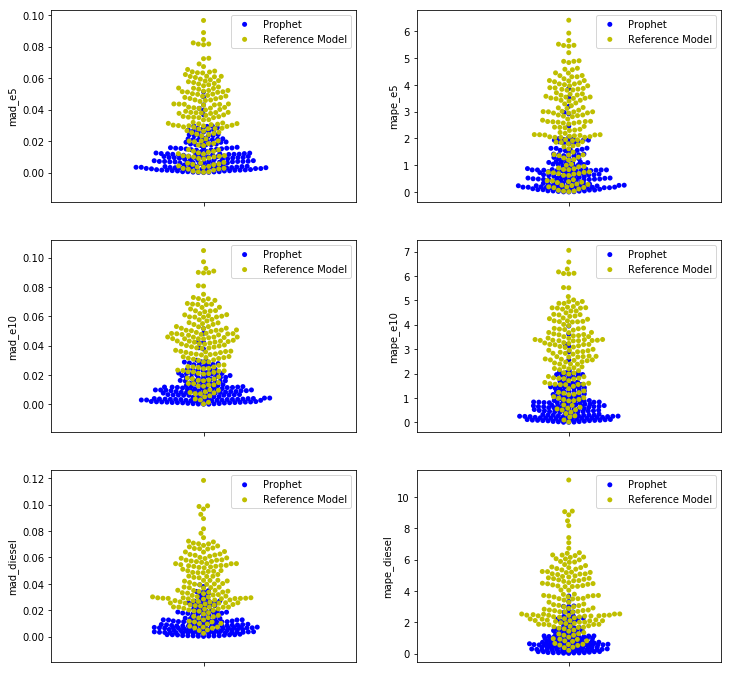

In [30]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))

sns.swarmplot(y='mad_e5', data=metrics, ax=ax1, color='b', label='Prophet')
sns.swarmplot(y='mad_e5', data=reference_model, ax=ax1, color='y', label='Reference Model')
ax1.legend()

sns.swarmplot(y='mape_e5', data=metrics, ax=ax2, color='b', label='Prophet')
sns.swarmplot(y='mape_e5', data=reference_model, ax=ax2, color='y', label='Reference Model')
ax2.legend()

sns.swarmplot(y='mad_e10', data=metrics, ax=ax3, color='b', label='Prophet')
sns.swarmplot(y='mad_e10', data=reference_model, ax=ax3, color='y', label='Reference Model')
ax3.legend()

sns.swarmplot(y='mape_e10', data=metrics, ax=ax4, color='b', label='Prophet')
sns.swarmplot(y='mape_e10', data=reference_model, ax=ax4, color='y', label='Reference Model')
ax4.legend()

sns.swarmplot(y='mad_diesel', data=metrics, ax=ax5, color='b', label='Prophet')
sns.swarmplot(y='mad_diesel', data=reference_model, ax=ax5, color='y', label='Reference Model')
ax5.legend()

sns.swarmplot(y='mape_diesel', data=metrics, ax=ax6, color='b', label='Prophet')
sns.swarmplot(y='mape_diesel', data=reference_model, ax=ax6, color='y', label='Reference Model')
ax6.legend()

### Step 3: Do the comparison on the full 100 data set, are the results for e5, e10 and diesel

#### Start with the reference model

Split data set: Two third for training and one third for testing

In [31]:
train_size = int(len(full_data_set) * 0.66)
train, test = full_data_set[0:train_size], full_data_set[train_size:len(full_data_set)]

In [32]:
reference_model = full_data_set.copy()

Calculate predicted values with simple moving average

In [33]:
reference_model['E5_hat'] = simple_moving_average(reference_model['E5'], len(train))
reference_model['E10_hat'] = simple_moving_average(reference_model['E10'], len((train)))
reference_model['DIESEL_hat'] = simple_moving_average(reference_model['DIESEL'], len(train))

In [34]:
reference_model.dropna(inplace=True)
reference_model = reference_model.reset_index()
reference_model = reference_model.rename(columns={'index': 'date'})
reference_model['date'] = reference_model['date'].apply(lambda x: x.strftime("%Y-%m-%d"))

Time series plot of 'true values' vs 'predicted values'

Text(0.5, 1.0, 'Prediction of E5 with reference model')

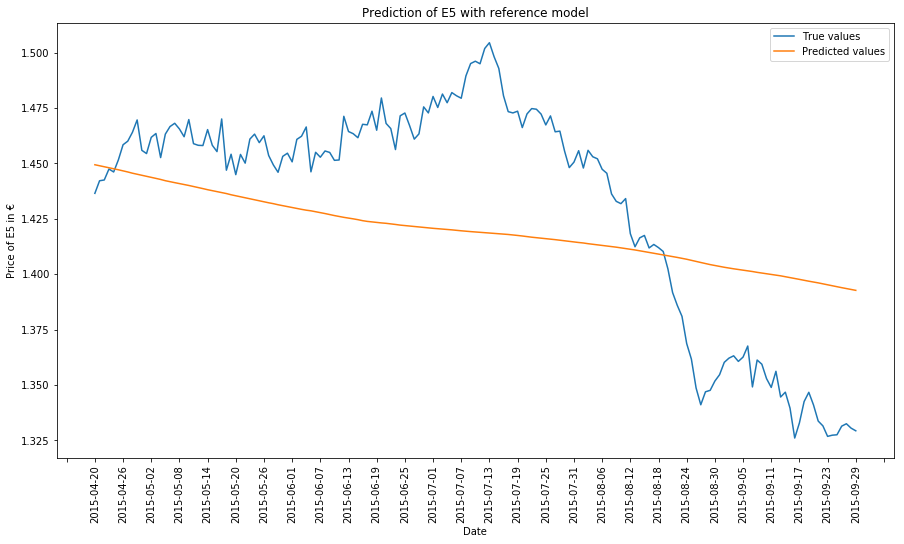

In [35]:
fig, ax = plt.subplots(figsize=(15,8))

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=90)

ax.plot(reference_model['date'], reference_model['E5'], label='True values')
#for index, row in df_cv.iterrows():
ax.plot(reference_model['date'], reference_model['E5_hat'], label='Predicted values')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price of E5 in €')
plt.title('Prediction of E5 with reference model')

Text(0.5, 1.0, 'Prediction of E10 with reference model')

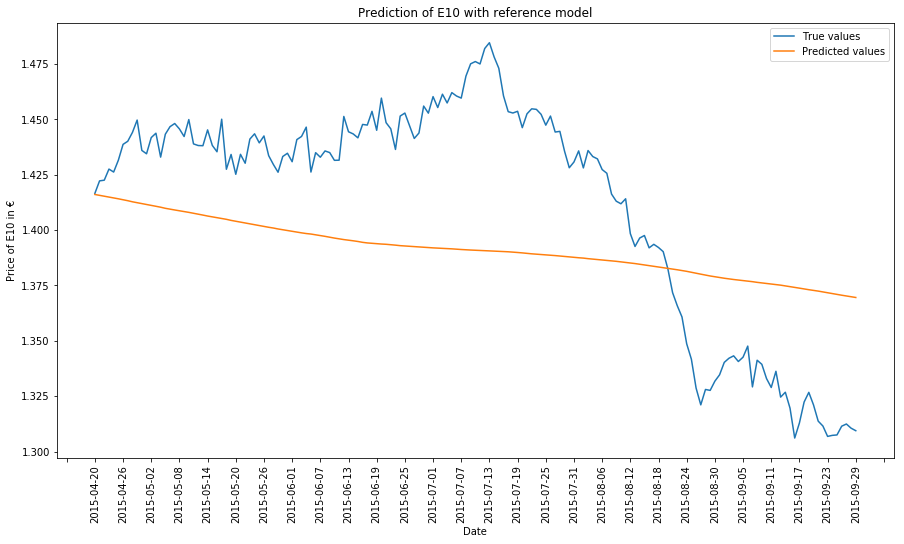

In [36]:
fig, ax = plt.subplots(figsize=(15,8))

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=90)

ax.plot(reference_model['date'], reference_model['E10'], label='True values')
#for index, row in df_cv.iterrows():
ax.plot(reference_model['date'], reference_model['E10_hat'], label='Predicted values')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price of E10 in €')
plt.title('Prediction of E10 with reference model')

Text(0.5, 1.0, 'Prediction of Diesel with reference model')

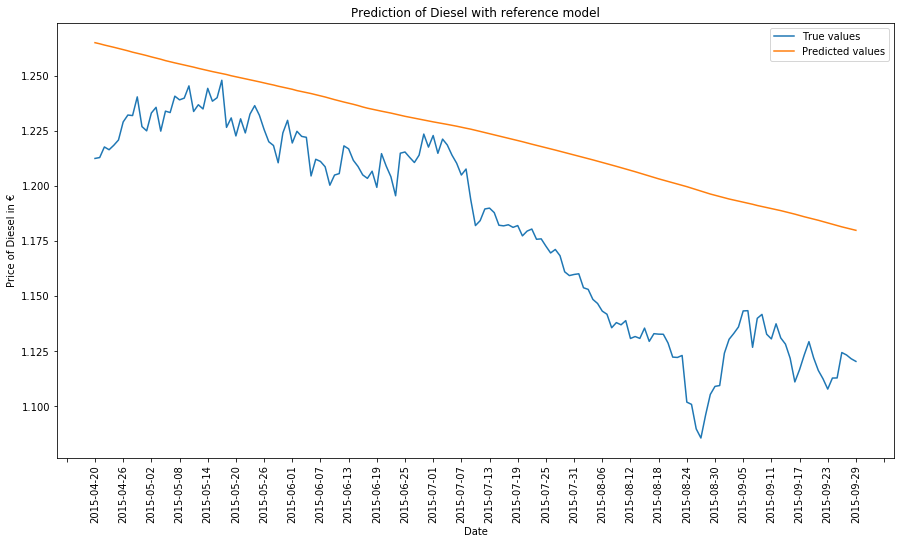

In [37]:
fig, ax = plt.subplots(figsize=(15,8))

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=90)

ax.plot(reference_model['date'], reference_model['DIESEL'], label='True values')
#for index, row in df_cv.iterrows():
ax.plot(reference_model['date'], reference_model['DIESEL_hat'], label='Predicted values')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price of Diesel in €')
plt.title('Prediction of Diesel with reference model')

Calculate MAD and MAPE

In [38]:
reference_model['mad_e5'] = reference_model.apply(mean_absolute_deviation, x='E5', x_hat='E5_hat', axis=1)
reference_model['mad_e10'] = reference_model.apply(mean_absolute_deviation, x='E10', x_hat='E10_hat', axis=1)
reference_model['mad_diesel'] = reference_model.apply(mean_absolute_deviation, x='DIESEL', x_hat='DIESEL_hat', axis=1)

reference_model['mape_e5'] = reference_model.apply(mean_abolute_percentage_error, x='E5', x_hat='E5_hat', axis=1)
reference_model['mape_e10'] = reference_model.apply(mean_abolute_percentage_error, x='E10', x_hat='E10_hat', axis=1)
reference_model['mape_diesel'] = reference_model.apply(mean_abolute_percentage_error, x='DIESEL', x_hat='DIESEL_hat', axis=1)

In [39]:
print("The average mean absolute deviation of E5: %1.4f€" %reference_model.mad_e5.mean())
print("The average mean absolute deviation of E10: %1.4f€" %reference_model.mad_e10.mean())
print("The average mean absolute deviation of Diesel: %1.4f€" %reference_model.mad_diesel.mean())
print("\n")
print("The average mean abolute percentage error of E5: %1.3f%%" %reference_model.mape_e5.mean())
print("The average mean abolute percentage error of E10: %1.3f%%" %reference_model.mape_e10.mean())
print("The average mean abolute percentage error of Diesel: %1.3f%%" %reference_model.mape_diesel.mean())

The average mean absolute deviation of E5: 0.0380€
The average mean absolute deviation of E10: 0.0437€
The average mean absolute deviation of Diesel: 0.0432€


The average mean abolute percentage error of E5: 2.664%
The average mean abolute percentage error of E10: 3.092%
The average mean abolute percentage error of Diesel: 3.736%


#### Facebook Prophet Model

Split data set: Two third for training and one third for testing

In [40]:
train, test = np.split(full_data_set, [int(0.66 * len(full_data_set))])

Calculate predicted values with the Facebook Prophet package

In [41]:
e5_full_data_set = full_data_set.reset_index()
e5_full_data_set = e5_full_data_set.rename(columns={'index': 'ds', 'E5': 'y'})
e5_prophet = facebook_prophet(e5_full_data_set, len(train))

e10_full_data_set = full_data_set.reset_index()
e10_full_data_set = e10_full_data_set.rename(columns={'index': 'ds', 'E10': 'y'})
e10_prophet = facebook_prophet(e10_full_data_set, len(train))

diesel_full_data_set = full_data_set.reset_index()
diesel_full_data_set = diesel_full_data_set.rename(columns={'index': 'ds', 'DIESEL': 'y'})
diesel_prophet = facebook_prophet(diesel_full_data_set, len(train))

INFO:fbprophet:Making 162 forecasts with cutoffs between 2015-04-20 00:00:00 and 2015-09-28 00:00:00
INFO:fbprophet:Making 162 forecasts with cutoffs between 2015-04-20 00:00:00 and 2015-09-28 00:00:00
INFO:fbprophet:Making 162 forecasts with cutoffs between 2015-04-20 00:00:00 and 2015-09-28 00:00:00


Time series plot of 'true values' vs 'predicted values'

Text(0.5, 1.0, 'Prediction of E5 with prophet')

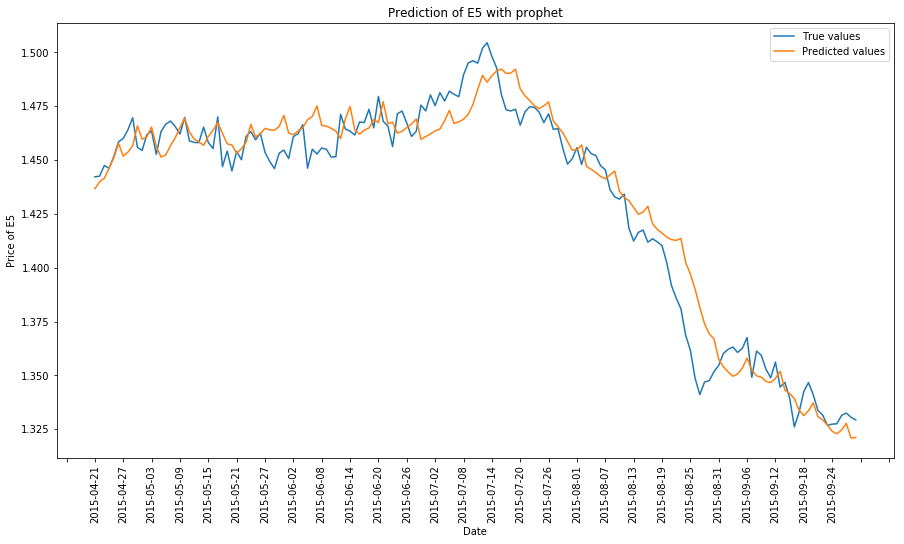

In [42]:
e5_prophet['ds'] = e5_prophet['ds'].apply(lambda x: x.date().strftime("%Y-%m-%d"))

fig, ax = plt.subplots(figsize=(15,8))

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=90)

ax.plot(e5_prophet['ds'], e5_prophet['y'], label='True values')
ax.plot(e5_prophet['ds'], e5_prophet['yhat'], label='Predicted values')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price of E5')
plt.title('Prediction of E5 with prophet')

Text(0.5, 1.0, 'Prediction of E10 with prophet')

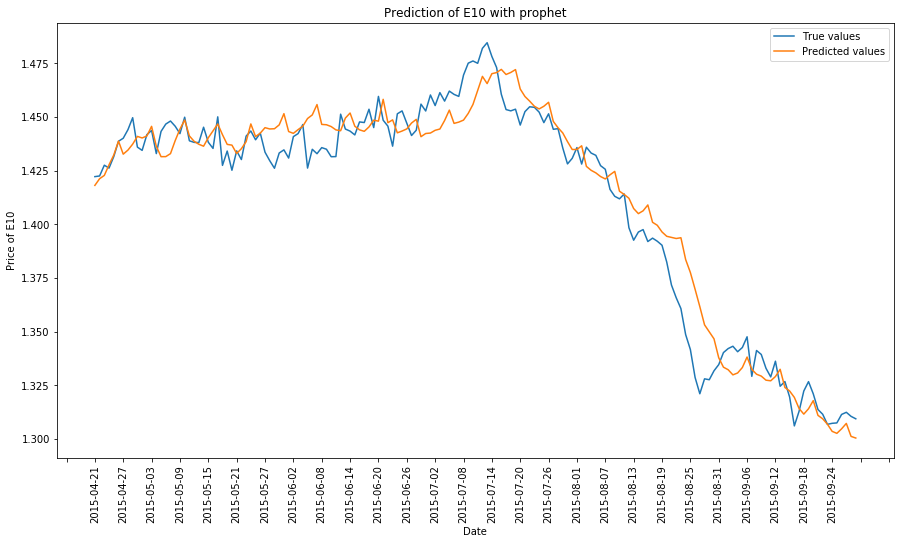

In [43]:
e10_prophet['ds'] = e10_prophet['ds'].apply(lambda x: x.date().strftime("%Y-%m-%d"))

fig, ax = plt.subplots(figsize=(15,8))

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=90)

ax.plot(e10_prophet['ds'], e10_prophet['y'], label='True values')
ax.plot(e10_prophet['ds'], e10_prophet['yhat'], label='Predicted values')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price of E10')
plt.title('Prediction of E10 with prophet')

Text(0.5, 1.0, 'Prediction of Diesel with prophet')

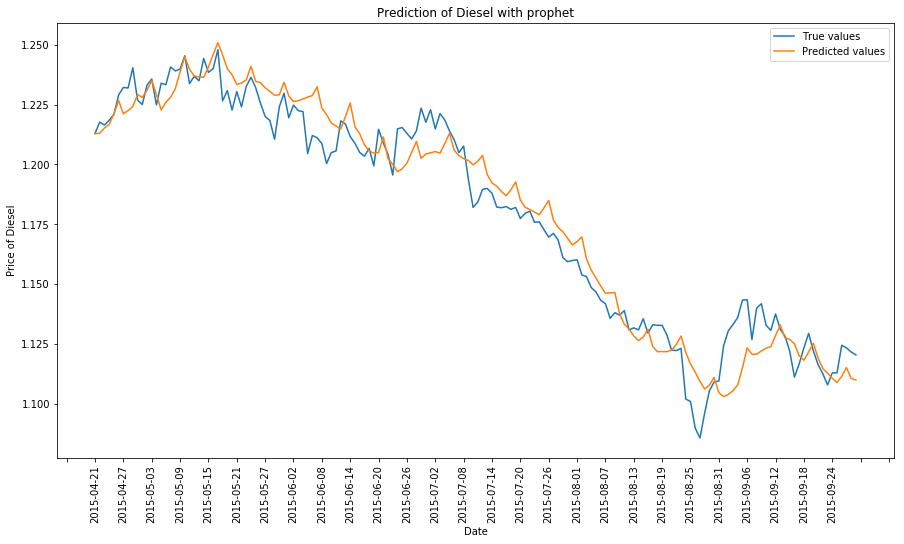

In [44]:
diesel_prophet['ds'] = diesel_prophet['ds'].apply(lambda x: x.date().strftime("%Y-%m-%d"))

fig, ax = plt.subplots(figsize=(15,8))

ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=90)

ax.plot(diesel_prophet['ds'], diesel_prophet['y'], label='True values')
ax.plot(diesel_prophet['ds'], diesel_prophet['yhat'], label='Predicted values')
ax.legend()
plt.xlabel('Date')
plt.ylabel('Price of Diesel')
plt.title('Prediction of Diesel with prophet')

Calculate MAD and MAPE

In [45]:
metrics = pd.DataFrame()

metrics['mad_e5'] = e5_prophet.apply(mean_absolute_deviation, x='y', x_hat='yhat', axis=1)
metrics['mad_e10'] = e10_prophet.apply(mean_absolute_deviation, x='y', x_hat='yhat', axis=1)
metrics['mad_diesel'] = diesel_prophet.apply(mean_absolute_deviation, x='y', x_hat='yhat', axis=1)

metrics['mape_e5'] = e5_prophet.apply(mean_abolute_percentage_error, x='y', x_hat='yhat', axis=1)
metrics['mape_e10'] = e10_prophet.apply(mean_abolute_percentage_error, x='y', x_hat='yhat', axis=1)
metrics['mape_diesel'] = diesel_prophet.apply(mean_abolute_percentage_error, x='y', x_hat='yhat', axis=1)

In [46]:
print("The average mean absolute deviation of E5: %1.4f€" %metrics.mad_e5.mean())
print("The average mean absolute deviation of E10: %1.4f€" %metrics.mad_e10.mean())
print("The average mean absolute deviation of Diesel: %1.4f€" %metrics.mad_diesel.mean())
print("\n")
print("The average mean abolute percentage error of E5: %1.3f%%" %metrics.mape_e5.mean())
print("The average mean abolute percentage error of E10: %1.3f%%" %metrics.mape_e10.mean())
print("The average mean abolute percentage error of Diesel: %1.3f%%" %metrics.mape_diesel.mean())

The average mean absolute deviation of E5: 0.0094€
The average mean absolute deviation of E10: 0.0094€
The average mean absolute deviation of Diesel: 0.0084€


The average mean abolute percentage error of E5: 0.660%
The average mean abolute percentage error of E10: 0.667%
The average mean abolute percentage error of Diesel: 0.719%


Compare the prediction results against the reference model (MAD and MAPE)

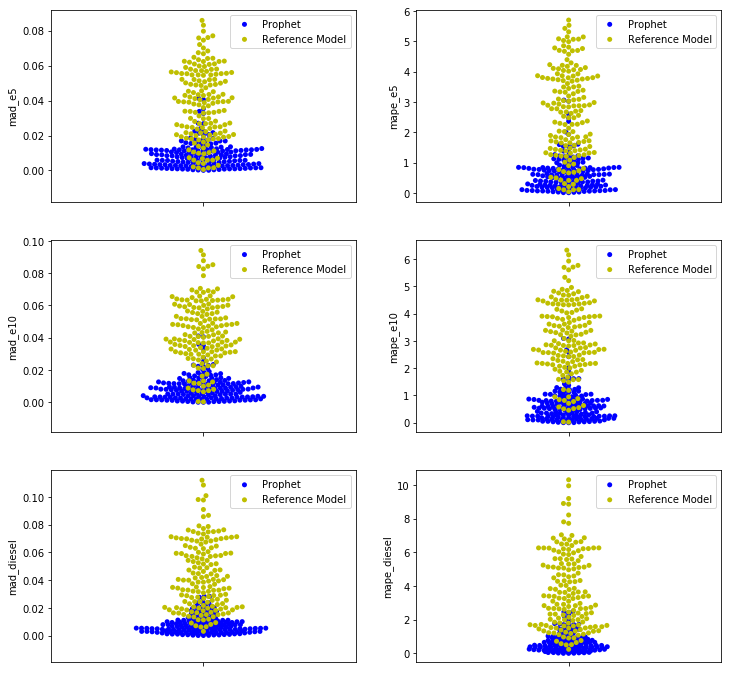

In [47]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))

sns.swarmplot(y='mad_e5', data=metrics, ax=ax1, color='b', label='Prophet')
sns.swarmplot(y='mad_e5', data=reference_model, ax=ax1, color='y', label='Reference Model')
ax1.legend()

sns.swarmplot(y='mape_e5', data=metrics, ax=ax2, color='b', label='Prophet')
sns.swarmplot(y='mape_e5', data=reference_model, ax=ax2, color='y', label='Reference Model')
ax2.legend()

sns.swarmplot(y='mad_e10', data=metrics, ax=ax3, color='b', label='Prophet')
sns.swarmplot(y='mad_e10', data=reference_model, ax=ax3, color='y', label='Reference Model')
ax3.legend()

sns.swarmplot(y='mape_e10', data=metrics, ax=ax4, color='b', label='Prophet')
sns.swarmplot(y='mape_e10', data=reference_model, ax=ax4, color='y', label='Reference Model')
ax4.legend()

sns.swarmplot(y='mad_diesel', data=metrics, ax=ax5, color='b', label='Prophet')
sns.swarmplot(y='mad_diesel', data=reference_model, ax=ax5, color='y', label='Reference Model')
ax5.legend()

sns.swarmplot(y='mape_diesel', data=metrics, ax=ax6, color='b', label='Prophet')
sns.swarmplot(y='mape_diesel', data=reference_model, ax=ax6, color='y', label='Reference Model')
ax6.legend()

### Unit Tests

In [48]:
import unittest

class TestFunctions(unittest.TestCase):
  
    def test_simple_moving_average(self):
        test_data = {'x': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]}
        test_df = pd.DataFrame(data=test_data)
        
        result1_data = {'x': [np.NaN, np.NaN, np.NaN, np.NaN, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0]}
        result1_df = pd.DataFrame(data=result1_data)
        pd.testing.assert_frame_equal(test_df.apply(simple_moving_average, window=4), result1_df)
        
        result2_data = {'x': [np.NaN, np.NaN, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0]}
        result2_df = pd.DataFrame(data=result2_data)
        pd.testing.assert_frame_equal(test_df.apply(simple_moving_average, window=2), result2_df)
    
    def test_mean_abolute_percentage_error(self):
        test_data = {'x': [1, 2, 3, 4, 5, 6, 12, 8, 2, 10], 'x_hat': [1, 3, -3, 0, -2, 3, 18, 6, 8, 8]}
        test_df = pd.DataFrame(data=test_data)
        pd.testing.assert_series_equal(test_df.apply(mean_abolute_percentage_error, axis=1), 
                                       pd.Series([0.0, 50.0, 200.0, 100.0, 140.0, 50.0, 50.0, 25.0, 300.0, 20.0]))
    
    
    def test_mean_absolute_deviation(self):
        test_data = {'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'x_hat': [1, 3, -3, 0, -2, 3, 5, 6, 12, 8]}
        test_df = pd.DataFrame(data=test_data)
        pd.testing.assert_series_equal(test_df.apply(mean_absolute_deviation, axis=1), 
                                       pd.Series([0, 1, 6, 4, 7, 3, 2, 2, 3, 2]))
    
    
unittest.main(argv=[''], verbosity=2, exit=False)

test_mean_abolute_percentage_error (__main__.TestFunctions) ... ok
test_mean_absolute_deviation (__main__.TestFunctions) ... ok
test_simple_moving_average (__main__.TestFunctions) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.023s

OK
